## Projeto do compensador avanço de fase (LEAD)

### Objetivo
- Tornar a resposta transitória mais rápida
- Dentro de uma faixa específica de frequências, adiciona fase suficiente à resposta em frequência do sistema de modo a aumentar sua margem de fase

### Características
- Acelera a resposta transitória
- Adiciona um pólo e um zero, ambos no SPE (eixo real)
- O pólo deve estar a esquerda do zero
- O pólo e o zero são alocados de modo a incorporar o LR
- Pode aumentar o valor do erro em regime permanente

### Função de Transferência

$C(s) = K \frac{1 + sT}{1 + s\alpha T} , 0 < \alpha < 1$

### Exercício  (SC_Cap6_01, exercício 04, página 09)

Projete um controlador em atraso para um sistema de controle com realimentação negativa cujas funções de transferência são dadas abaixo.


$G(s) = \frac{5}{0,2s+1}$
$H(s) = \frac{0,01}{0,04s+1}$


Deseja-se obter um erro de regime permanente inferior a 2%, margem de ganho MG > 2, e margem de fase MF > 30°



In [1]:
# Bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl

In [2]:
# Requisitos do projeto
ERRO_DESEJADO = 2/100
MG_DESEJADA = 2
MF_DESEJADA = 30

# Verifica se os requisitos do projeto foram atendidos
def testar_requisitos(erro, MF, MG):
    requisitos_nao_atendidos = []
    if erro > ERRO_DESEJADO:
        print(f"Erro NÃO atendido: {erro:.2%} (máx: {ERRO_DESEJADO:.2%})")
        requisitos_nao_atendidos.append("erro")
    if MF <= MF_DESEJADA:
        print(f"Margem de fase NÃO atendida: {MF:.2f}° (mín: {MF_DESEJADA}°)")
        requisitos_nao_atendidos.append("MF")
    if MG <= MG_DESEJADA:
        print(f"Margem de ganho NÃO atendida: {MG:.2f} dB (mín: {MG_DESEJADA} dB)")
        requisitos_nao_atendidos.append("MG")
    return requisitos_nao_atendidos

In [3]:
# Retorna as margens de estabilidade e afins
def margens_de_estabilidade(ftma):
  gm, pm, _, wpc, wgc, _ = ctrl.stability_margins(ftma)
  
  MG = gm  # Margem de ganho
  MF = pm  # Margem de fase
  freq0db = wgc  # Frequência de cruzamento de ganho (0 dB)
  freq180 = wpc  # Frequência de cruzamento de fase (-180°)
  fase_freq0db = pm - 180  # Fase na frequência de 0 dB
  ganho_freq180 = -(20 * np.log10(gm))  # Ganho na frequência de -180°

  return MG, MF, freq0db, freq180, fase_freq0db, ganho_freq180

In [4]:
# Define o valor de k_p do compensador proporcional
def k_proporcional(G0, H0):
  k_p = ((1 / ERRO_DESEJADO) - 1) / (G0*H0)
  return k_p

In [5]:
def erro_estacionario(G0, H0, C0):
  return 1 / (1 + (G0*H0*C0))

### Sistema sem compensação
$K = 1$ e $C(s) = 1$

In [6]:
# Funções de transferência
G = ctrl.tf([5],[0.2, 1])
G0 = G(0).real
H = ctrl.tf([0.01],[0.04, 1])
H0 = H(0).real

erro = erro_estacionario(G0, H0, 1)

L_sem_compensacao = G * H

MG, MF, _, _, _, _ = margens_de_estabilidade(L_sem_compensacao)

resultado = testar_requisitos(erro, MF, MG)

if not resultado:
  print(f'\nO sistema sem compensação já atende os requisitos do projeto')
else:
  print(f'\nO sistema sem compensação não atende os requisitos do projeto. É necessário projetar um compensador')

Erro NÃO atendido: 95.24% (máx: 2.00%)

O sistema sem compensação não atende os requisitos do projeto. É necessário projetar um compensador


### Sistema com compensação proporcional
$C(s) = k_p$

In [7]:
K = 1

if 'erro' in resultado:
  K = float(k_proporcional(G0, H0))
  print(f"Para e(∞) < {ERRO_DESEJADO}, K > {K:.2f}\n")
  
  # A partir do K encontrado, determinar MF e MG e realizar novamente os testes
  L_proporcional = K*G*H

  # Encontrar margens
  MG, MF, freq0db, freq180, fase_freq0db, ganho_freq180 = margens_de_estabilidade(L_proporcional)
  
  print(f"Para o sistema com compensação tipo P (k_p = {K:.2f}), temos que:\n")
  
  print(f"- A frequência de ganho 0dB é {freq0db:.0f} rad/s.")
  print(f"- A fase na frequência de ganho 0 dB é {fase_freq0db:.2f}°.\n")
  
  print(f"- A frequência de fase -180° é {freq180:.0f} rad/s.")
  print(f"- O ganho na frequência de fase -180° é {ganho_freq180:.2f} dB.\n")
  
  print(f"- A margem de ganho é {MG:.0f} dB.")
  print(f"- A margem de fase é {MF:.0f}°.")
  
  # Testar os requisitos
  erro = erro_estacionario(G0, H0, C0 = K)
  resultado = testar_requisitos(erro, MF, MG)

  if not resultado:
    print(f'\nO compensador proporcional k_p = {K:.2f} foi suficiente para atender os requisitos do projeto')
  else:
    print(f'\nO compensador proporcional k_p = {K:.2f} NÃO foi suficiente para atender os requisitos do projeto')

Para e(∞) < 0.02, K > 980.00

Para o sistema com compensação tipo P (k_p = 980.00), temos que:

- A frequência de ganho 0dB é 76 rad/s.
- A fase na frequência de ganho 0 dB é -158.08°.

- A frequência de fase -180° é nan rad/s.
- O ganho na frequência de fase -180° é -inf dB.

- A margem de ganho é inf dB.
- A margem de fase é 22°.
Margem de fase NÃO atendida: 21.92° (mín: 30°)

O compensador proporcional k_p = 980.00 NÃO foi suficiente para atender os requisitos do projeto


### Sistema com compensação Avanço de Fase
Nesse caso, temos que o valor da margem de fase é inferior ao desejado.

Uma solução é utilizar um compensador avanço de fase para aumentar a margem de fase.

### Gráfico de variação de $ϕ_m$ em funçao de $α$
![graficofasealfa.png](graficofasealfa.png)

In [8]:
alfa = ''
if 'MF' in resultado:
  MF_comp = MF_DESEJADA + 10 # compensar os desvios de fase aproximados na elaboração do diagrama de Bode
  
  acrescimo_fase = MF_comp - MF
  avanco_max = acrescimo_fase + 7
  
  print(f"Verificar no gráfico de variação de ϕ_m em funçao de α, o valor de α para o ϕ_m = {avanco_max}\n", flush=True)
  alfa = input("Valor de α: ")

Verificar no gráfico de variação de ϕ_m em funçao de α, o valor de α para o ϕ_m = 25.083590760113367



In [9]:
if 'MF' in resultado:
  alfa = float(alfa)
  mag = np.sqrt(alfa)
  magdB = 20*np.log10(mag)
  
  w = np.logspace(-3, 3, 100000)
  ganho, fase, frequencia = ctrl.bode_plot(L_proporcional, w, dB=True, Hz=False, deg=True, plot=False)
  ganho = 20*np.log10(ganho)
  
  indice = np.argmin(np.abs(ganho - magdB))
  freq_wm = frequencia[indice]
  
  T = 1/(freq_wm*mag)
 
  C = ctrl.tf([float(K)*T, float(K)], [alfa*T, 1])
  C0 = C(0).real
    
  L_avanco = G*H*C
  
  # Encontrar margens
  MG, MF, freq0db, freq180, fase_freq0db, ganho_freq180 = margens_de_estabilidade(L_avanco)
  
  print(f"Para o sistema com compensação tipo LEAD (K = {K:.2f}, a = {alfa:.2f}, T = {T:.2f}), temos que:\n")
  
  print(f"- A frequência de ganho 0dB é {freq0db:.0f} rad/s.")
  print(f"- A fase na frequência de ganho 0 dB é {fase_freq0db:.2f}°.\n")
  
  print(f"- A frequência de fase -180° é {freq180:.0f} rad/s.")
  print(f"- O ganho na frequência de fase -180° é {ganho_freq180:.2f} dB.\n")
  
  print(f"- A margem de ganho é {MG:.0f} dB.")
  print(f"- A margem de fase é {MF:.0f}°.")
  
  # Testar os requisitos
  erro = erro_estacionario(G0, H0, C0)
  resultado = testar_requisitos(erro, MF, MG)

  if not resultado:
    print(f'\nO compensador avanço de fase (K = {K:.2f}, a = {alfa:.2f}, T = {T:.2f}) foi suficiente para atender os requisitos do projeto')
  else:
    print(f'\nO compensador avanço de fase (K = {K:.2f}, a = {alfa:.2f}, T = {T:.2f}) NÃO foi suficiente para atender os requisitos do projeto')

Para o sistema com compensação tipo LEAD (K = 980.00, a = 0.40, T = 0.02), temos que:

- A frequência de ganho 0dB é 97 rad/s.
- A fase na frequência de ganho 0 dB é -137.18°.

- A frequência de fase -180° é nan rad/s.
- O ganho na frequência de fase -180° é -inf dB.

- A margem de ganho é inf dB.
- A margem de fase é 43°.

O compensador avanço de fase (K = 980.00, a = 0.40, T = 0.02) foi suficiente para atender os requisitos do projeto


### Comparando os gráficos com compensação P e LEAD

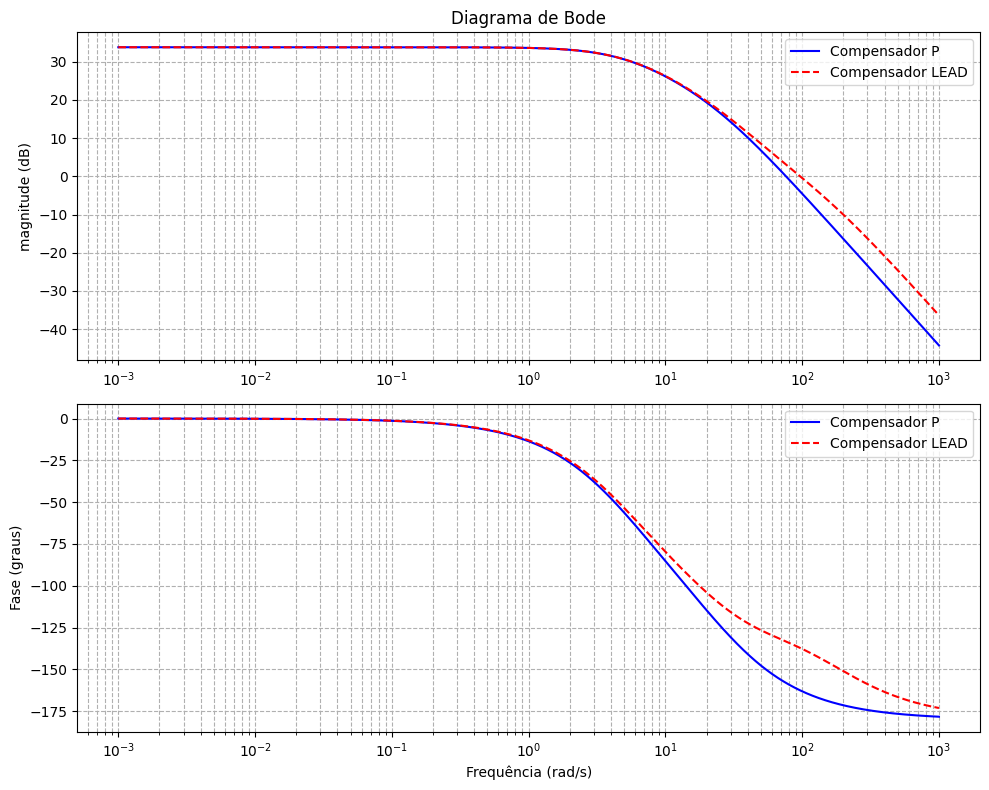

In [10]:
w = np.logspace(-3, 3, 100000)

ganho1, fase1, frequencia = ctrl.bode_plot(L_proporcional, w, dB=True, Hz=False, deg=True, plot=False)
ganho2, fase2, _ = ctrl.bode_plot(L_avanco, w, dB=True, Hz=False, deg=True, plot=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.semilogx(frequencia, 20 * np.log10(ganho1), 'b', label='Compensador P')
ax1.semilogx(frequencia, 20 * np.log10(ganho2), 'r--', label='Compensador LEAD')
ax1.set_title('Diagrama de Bode')
ax1.set_ylabel('magnitude (dB)')
ax1.legend()
ax1.grid(True, which="both", ls="--")

ax2.semilogx(frequencia, np.degrees(fase1), 'b', label='Compensador P')
ax2.semilogx(frequencia, np.degrees(fase2), 'r--', label='Compensador LEAD')
ax2.set_xlabel('Frequência (rad/s)')
ax2.set_ylabel('Fase (graus)')
ax2.legend()
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()

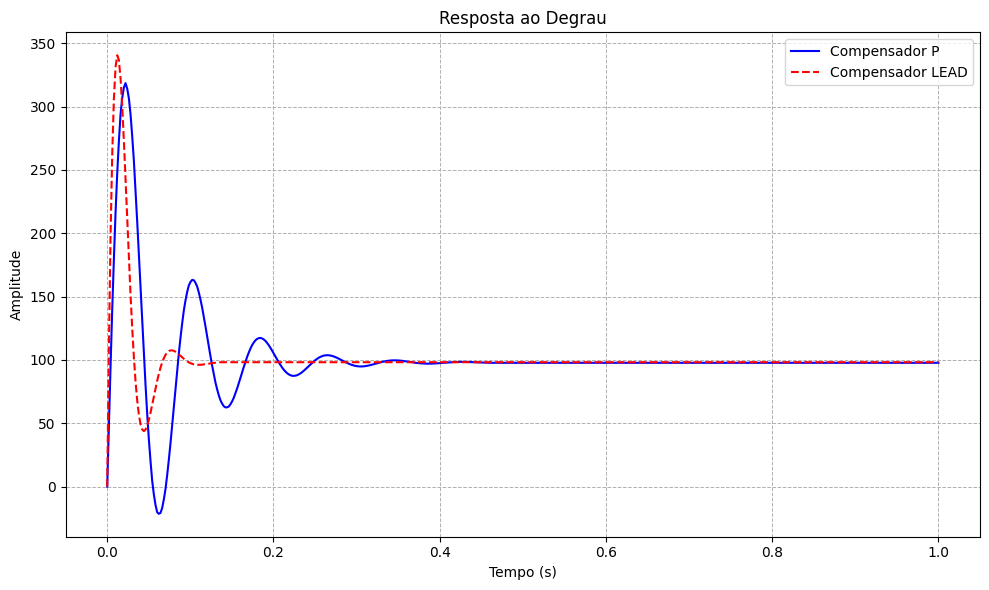

In [11]:
T_proporcional = ctrl.feedback(G*K, H)
T_avanco = ctrl.feedback(G*C, H)

t1, y1 = ctrl.step_response(T_proporcional)
t2, y2 = ctrl.step_response(T_avanco)

# fazer ambas as respostas para mesmo intervalo de tempo
t = np.linspace(0, 1, num=500)
y1 = np.interp(t, t1, y1)
y2 = np.interp(t, t2, y2)

plt.figure(figsize=(10, 6))
plt.plot(t, y1, 'b', label='Compensador P')
plt.plot(t, y2, 'r--', label='Compensador LEAD')

plt.title('Resposta ao Degrau')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.grid(True, which="both", linestyle="--", linewidth=0.7)
plt.legend()
plt.tight_layout()
plt.show()